# Données reconnaissance du locuteur (Chirac/Mitterrand)

Ceci est un notebook qui va réaliser la tâche de classification de documents appliquée au dataset des présidents Jacques Chirac et François Mitterand.

## Aperçu du dataset:
Cette base est composée de 54413 expressions et phrases tirés de différents discours des anciens présidents français Chirac et Mitterand, chaque expression (document) est étiquetée par un label C ou M (pour Chirac ou Mitterand) et qui indique le président ayant dit cette expression.

Il est à noter que les classes ne sont pas équilibrées, on note une forte présence des expressions du président Chirac que celles du président Mitterand.

L'objectif de ce projet est d'apprendre un classifieur binaire qui permet de prédire pour une expression donnée (Nouvelle expressions provenant de l'un des deux présidents), si elle a été prononcée par le président Chirac ou Mitterand. Le modèle proposé sera ensuite entrainé sur un nouveau test set auquel on n'a pas accès durant la phase d'apprentissage.

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
# IMPORT ALL LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import codecs
import re
import os.path

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
from tqdm import tqdm
import os
import time

# Document classification :

## A. Processing chain design
**Main steps:**
1. Data reading \& importation
    - The corpus can be loaded in RAM (otherwise, you should use a *data loader* to bufferise the importation)
    - Encoding is a big problem: you have to make sure that the data are correctly read.
2. Data pre-processing, transformation \& filtering
    - remove *useless* information: figures, ponctuations, capitals, *etc*... **usefulness depends on applications! [obviously]**
    - Segment into words (=*Tokenization*)
    - Elimination of stop-words
    - Stemming/lemmatization (rootization)
    - Byte-pair encoding to find compound words (e.g. Sorbonne University, City of Paris, Prime Minister, etc...)
3. Digital data processing (Bag-of-Words)
    - Normalization *term-frequency* / binarization
    - Inverse document frequency* normalization
    - Elimination of rare words, too frequent words
    - Construction of separability criteria to eliminate words etc...
4. Learning a classifierµ
    - Choice of the type of classifier
    - Adjustment of the parameters of the classifier (regularization, balancing, etc...)

## B. Exploitation of the processing chain

This step is called the realization of a campaign of experiments: it is the key point that we want to work on in NLP this year.
1. It is impossible to test all the combinations in relation to the above proposals... Therefore, we have to eliminate some of them.
    - By discussing with the business experts
    - By doing preliminary tests
1. After this first filtering, we must:
    - Choose an evaluation that is reliable and not too slow (cross-validation, leave-one-out, split learning/single test)
    - Run large experiments
        - = *grid-search
        - parallelise on several machines
        - know how to run on a server and disconnect
1. Collect and analyze results


## C. Inference & industrialization

The inference is then very classical: the optimal processing chain is able to process new documents

If you're looking for an evaluation method that is reliable and not too slow, one good option is split learning with a single test set. This approach involves splitting your data into training and test sets, where the training set is used to fit your model and the test set is used to evaluate its performance.

Splitting your data into a training and test set allows you to assess the performance of your model on data it has not seen before. This can help you avoid overfitting, which occurs when your model is too complex and performs well on the training data but poorly on new data.

Compared to more computationally intensive methods like cross-validation or leave-one-out, split learning with a single test set is much faster and can be easily implemented. However, it's important to note that the size and representativeness of your test set can impact the reliability of your evaluation. To ensure reliable results, it's important to choose a test set that is representative of the data you will encounter in the future and to evaluate your model's performance on multiple test sets if possible.

## Etape 1: chargement des données

In [23]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        # 
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [24]:
fname = "./datasets/corpus.tache1.learn.utf8.txt"
alltxts,alllabs = load_pres(fname)

# All the data
X = np.array(alltxts)
Y = np.array(alllabs)

# Splitting into train test
X_train, X_test, Y_train, Y_test = train_test_split(alltxts, alllabs, test_size=0.2, shuffle=False)

X_train, X_test, Y_train, Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)

## Regrouping all documents into one big document
text = ' '.join([document for document in X_train])

train_size = len(X_train)
test_size = len(X_test)
print('Train set length : ',train_size)
print('Test set length  : ',test_size)

Train set length :  6990
Test set length  :  1748


In [7]:
print(len(X),len(Y))
print(X[0])
print(Y[0])
print(X[-1])
print(Y[-1])

8738 8738
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 On est venu ici, non pas pour donner le moindre conseil superflu mais on a évoqué en terminant deux problèmes sur lesquels je voudrais mettre l'
1


Remarques:
- Pour les étiquettes y : 
    - L'étiquette 1 représente la classe Chirac
    - L'étiquette -1 représente la classe Mitterand

## Etape 02 : Prétraitement du texte

### Chaîne de traitements pour le pré-processing de texte:

- sélectionner des lignes
- marquer les ponctuations multiples
- marquer les majuscules multiples
- suppression de la ponctuation
- suppression des chiffres
- mettre en minuscule
- normaliser
- supprimer les stopwords
- stemming

Il s'agit dans cette étape d'appliquer des prétraitements sur les données textuelles (corpus)

In [8]:
# Fonctions de prétraitements du texte

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as stopwords

import unicodedata
import string
import re

punc = string.punctuation  # recupération de la ponctuation
punc += '\n\r\t'

def lower(corpus, markers = None):
    """ Met le texte en minuscules sauf les mots correspondant aux marqueurs."""
    return [ " ".join( word.upper() if word in markers else word.lower() for word in txt.split() ) for txt in corpus ]

def normalize(corpus):
    """ Suppression des accents et des caractères non normalisés """
    return [ unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8") for txt in corpus ]

def del_punc(corpus):
    """ Enlève les ponctuations."""
    return [ txt.translate(str.maketrans(punc, ' ' * len(punc))) for txt in corpus ]

def del_num(corpus):
    """ Enlève les chiffres."""
    return [ re.sub('[0-9]+', '', txt) for txt in corpus ] # remplacer une séquence de chiffres par rien

def mark_mulpunc(corpus, marker='MULPUNC'):
    """ Transformation des séquences de ponctuation en un marqueur spécifique (marker) """
    ponctuation = '[' + string.punctuation + ']{2,}'
    return [ re.sub(ponctuation, ' ' + marker + ' ', txt) for txt in corpus ]

def mark_mulmaj(corpus, marker='MULMAJ', n=5):
    """ On ne supprime pas les séquences complètement en majuscule, mais on les fait suivre d'un marqueur (marker)
        @return : str, txt transformé
    """
    marked_corpus = []
    
    for txt in corpus:
        all_maj = re.findall('[A-Z]+[A-Z0-9]{1,}', txt)
        for maj in all_maj:
            #txt = re.sub(maj, maj + ' ' + 'MULMAJ ', txt)
            txt = re.sub(maj,(maj + ' ') * n  + maj, txt)
        marked_corpus.append(txt)
    
    return marked_corpus

def stem(corpus, language):
    """ Racinisation des textes du corpus.
    """
    # Stemmer dans la langue choisie
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    return [ ' '.join([ stemmer.stem(word) for word in txt.split() ]) for txt in corpus ]

def del_stopwords(corpus, language):
    """ Elimination des stopwords.
    """
    # Liste des stopwords à supprimer (dans la langue choisie)
    stopwords_ = set(stopwords.words(language))
    return [ ' '.join([ word for word in txt.split() if word not in stopwords_ ]) for txt in corpus ]

def select_line(corpus, line=None):
    """ Fonction sélectionnant pour chaque texte du corpus:
            * l'intégralité du texte si line = None
            * la première ligne du texte si line = 0
            * la dernière ligne du texte si line = -1
        A noter que dans les données IMDb, chaque revue a pour dernière ligne ''.
    """
    if line != None:
        return [ txt.split('\n')[:-1][line] for txt in corpus ]
    return corpus

In [9]:
# Nombre moyen de mots par discours
cpt = []
for r in X_train:
    cpt.append(len(r.split()))
np.mean(cpt)

21.543204577968528

In [10]:
import copy
import string
import nltk
from collections import Counter

def text_processor(corpus, language, line=None, mark_punc=False, mark_maj=False, no_punc=False, no_num=False, lowercase=False, norm=False, no_stopwords=False, stemming=False, rare_words = False, frequent_words = False, rare_threshold = 5, frequent_threshold = 100):
    """ Processing paramétrique d'un corpus de texte (cf. chaîne de traitements ci-dessus).
        @param corpus: list(str), corpus de textes
        @param language: {'english', 'french'}
        @param line: {None, 0, -1}, paramètre line de la fonction select_line
        @param mark_mulpunc: {0,1}, vaut 1 si on applique la fonction mark_mulpunc
        @param mark_mulmaj: {0,1}, vaut 1 si on applique la fonction mark_mulmaj
        @param del_punc: {0,1}, vaut 1 si on applique la fonction del_punc
        @param del_num: {0,1}, vaut 1 si on applique la fonction del_num
        @param lower: {0,1}, vaut 1 si on applique la fonction lower
        @param normalize: {0,1}, vaut 1 si on applique la fonction normalize
        @param del_stopwords: {0,1}, vaut 1 si on applique la fonction del_stopwords
        @param stem: {0,1}, vaut 1 si on applique la fonction stem
        @return processed_corpus: list(str), corpus traité
    """
    # Récupération de la ponctuation
    punc = string.punctuation
    punc += '\n\r\t'
    
    # Multiplication multiple
    mulpunc = '[' + string.punctuation + ']{2,}'
    
    # Initialisation du stemmer
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    
    # Liste des stopwords à supprimer (dans la langue choisie)
    stopwords_ = set(stopwords.words(language))
    
    # Sélection de lignes si spécifié
    processed_corpus = select_line(copy.deepcopy(corpus), line=line)

    
    for i in range(len(processed_corpus)):
        text = processed_corpus[i]
        if mark_punc:
            text = re.sub(mulpunc, ' ' + 'MULPUNC' + ' ', text)
        if mark_maj:
            all_maj = re.findall('[A-Z]+[A-Z0-9]{1,}', text)
            for maj in all_maj:
                text = re.sub(maj, maj + ' ' + 'MULMAJ ', text)
        if no_punc:
            text = text.translate(str.maketrans(punc, ' ' * len(punc)))
        if no_num:
            text = re.sub('[0-9]+', '', text)
        if lowercase:
            markers = ['MULPUNC','MULMAJ']
            text = " ".join( word.upper() if word in markers else word.lower() for word in text.split() )
        if no_stopwords:
            text = ' '.join( word for word in text.split() if word not in stopwords_ )
        if norm:
            text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        if stemming:
            text = ' '.join( stemmer.stem(word) for word in text.split() )
            
        # Remove rare/frequent words
        if rare_words:
            tokens = nltk.word_tokenize(text)
            word_counts = Counter(tokens)
        
            filtered_tokens = []
            for token in tokens:
                if rare_threshold <= word_counts[token]:
                    filtered_tokens.append(token)

            text = " ".join(filtered_tokens)
        if frequent_words:
            tokens = nltk.word_tokenize(text)
            word_counts = Counter(tokens)
        
            filtered_tokens = []
            for token in tokens:
                if word_counts[token]<= frequent_threshold:
                    filtered_tokens.append(token)

            text = " ".join(filtered_tokens)

        processed_corpus[i] = text
    
    return processed_corpus

In [11]:
import time
import string

start = time.time()
corpus = text_processor(X_train, language='french', line=None, mark_punc=True, mark_maj=True, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
print('Time elapsed: ', time.time() - start)

Time elapsed:  2.526585340499878


## Etape 03 : Extraction du vocabulaire et BoW
### Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?

### Exploration préliminaire des données présidentielles:

### 3.1 Taille d'origine du vocabulaire:

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)
X_processed = vectorizer.fit_transform(X)

# Affichage
vocabulaire = vectorizer.get_feature_names_out()
print('Taille du vocabulaire = ', len(vocabulaire))
print(X_processed.toarray())

Taille du vocabulaire =  1983
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 3.2 Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]

In [13]:
from collections import Counter

xarray = X_processed.toarray()
occurrences = np.sum(xarray, axis=0)
counter = Counter( { vocabulaire[i] : occurrences[i] for i in range(len(vocabulaire)) } )
counter.most_common(100)

[('de', 700.1288987522059),
 ('la', 539.0639743802882),
 ('et', 461.5949584798838),
 ('le', 405.92594880031135),
 ('les', 391.73314265586396),
 ('est', 348.59288914273975),
 ('des', 341.714780253232),
 ('en', 296.8148133938232),
 ('que', 282.43895974464976),
 ('qui', 263.5115267468325),
 ('nous', 247.21185936465),
 ('un', 247.16050230548447),
 ('une', 243.861146509723),
 ('pour', 236.64844926245766),
 ('vous', 222.94714702294797),
 ('dans', 220.1062951859059),
 ('il', 219.48087340119005),
 ('je', 219.4325828213638),
 ('du', 207.42051667831805),
 ('ce', 184.3780023951096),
 ('plus', 174.4678944511841),
 ('au', 173.0250746596635),
 ('pas', 172.3622662527641),
 ('notre', 152.13971573951255),
 ('france', 145.2769642578487),
 ('nos', 142.09724347995393),
 ('ne', 138.0895436031864),
 ('qu', 137.71811397817433),
 ('par', 135.08951162657164),
 ('elle', 133.30831895104066),
 ('sur', 129.43520148241612),
 ('cette', 124.3106977608444),
 ('avec', 124.2793451671014),
 ('mais', 122.00728027275159),


### 3.3 Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]

8738 lignes Chirac


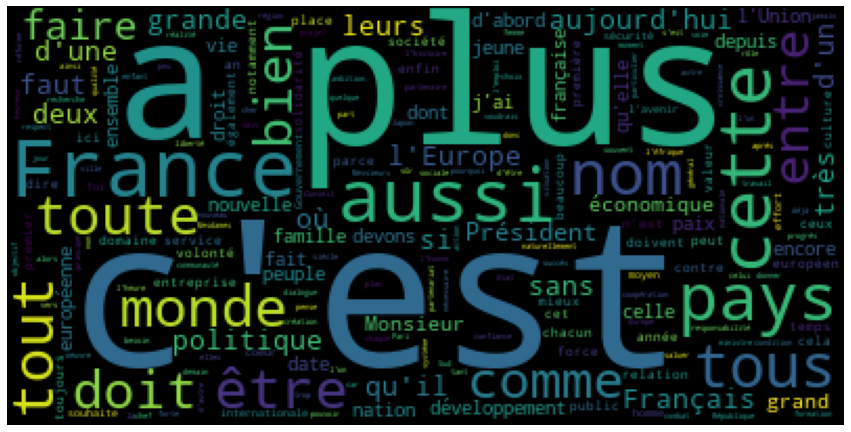

In [14]:
# Wordcloud sur les discours de Chirac

from wordcloud import WordCloud
from PIL import Image

x_chirac = [ X[i] for i in range(len(X)) if Y[i] == 1 ]
print('{} lignes Chirac' .format(len(X)))

text_chirac = ' '.join( [ d for d in x_chirac ] )
stopwords_ = set(stopwords.words('french'))

wc = WordCloud(background_color="black", max_words=500,
               collocations=False, stopwords=stopwords_, contour_width=3, contour_color='lightsteelblue')
wc.generate(text_chirac)

# Affichage
plt.figure(figsize = (15,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

1402 lignes Mitterand


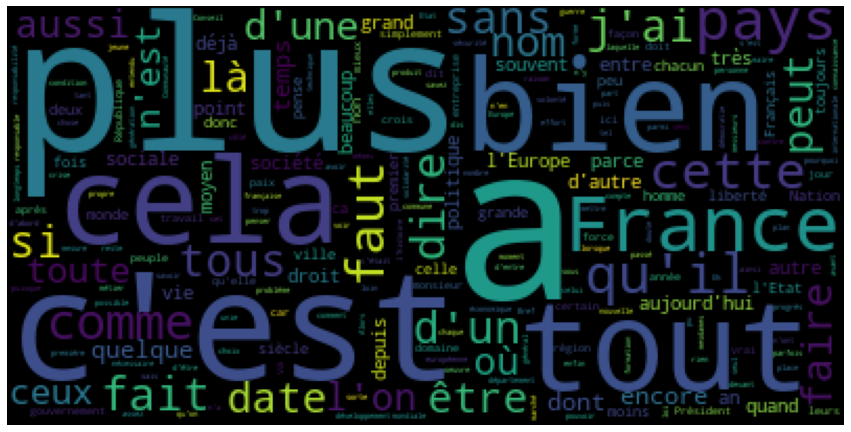

In [15]:
# Wordcloud sur les discours du président Mitterand

# from PIL import Image

x_mitterand = [ X[i] for i in range(len(X_train)) if Y[i] == -1 ]
print('{} lignes Mitterand' .format(len(x_mitterand)))

text_mit = ' '.join( [ d for d in x_mitterand ] )
stopwords_ = set(stopwords.words('french'))

wc = WordCloud(background_color="black", max_words=500,
               collocations=False, stopwords=stopwords_, contour_width=3, contour_color='lightsteelblue')
wc.generate(text_mit)

# Affichage
plt.figure(figsize = (15,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

### 3.4 Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

Dans la classification des discours, le l'odds ratio est une mesure de l'association entre une caractéristique (par exemple, un mot) et une classe particulière (M ou C dans notre cas). La formule de l'odds ratio est la suivante :

$$ \text{odds ratio(mot)} = \frac{p(\text{mot} | \text{positif})  *  (1 - p(\text{mot} | \text{negatif}))}{p(\text{mot} | \text{negatif})  *  (1 - p(\text{mot} | \text{positif}))} $$

où:

$$p(mot|C)$$  est la probabilité d'observer le mot étant donné que la classe est Chirac.

$$p(mot|M)$$  est la probabilité d'observer le mot étant donné que le classe est Mitterand.

L'odds ratio nous indique combien il est plus probable que le mot apparaisse dans la classe M par rapport à la classe C. Si l'odds ratio est supérieur à 1, cela suggère que le mot est davantage associé à la classe M, tandis que si l'odds ratio est inférieur à 1, cela suggère que le mot est  associé à la classe C.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

def compute_odd_ratio(X, Y, eps=0.1,Vectorizer=None):
    """
    Calculates the odds ratio for each word in the corpus.
    If a word's odds ratio is > 1 : it is more likely from a positive reviews, otherwise it's from a negative one.
    
    Arguments:
        X: a list of documents, where each document is a string
        Y: a list of labels for each document in the corpus (Hypothesis that the labels are either 0 or 1)
        eps : Hyperparameter to avoid multiplying by a null probability while calculating odds ratio, changing it gives different results
        ngram_range : hyperparameter of the vectorizer
        Vectorizer : Type of vectorizer, by default it's TF-IDF, we can use CountVectorizer by passing by instanciating it and passing it in the parameter
    Returns:
        A dictionary of words in the corpus's vocabulary, each word is associated with its odds ratio
    """
    X_0 = [X[i] for i in range(len(X)) if Y[i] == -1] ## negative reviews
    X_1 = [X[i] for i in range(len(X)) if Y[i] == 1] ## positive reviews
        
    ## Extract vocabulary of negative reviews and the frequency of each word used
    if Vectorizer is None : vectorizer_0 = TfidfVectorizer()
    else : vectorizer_0 = Vectorizer
    x_0 = vectorizer_0.fit_transform(X_0)
    voc_0 = vectorizer_0.get_feature_names_out()
    word_counts_0 = {}
    for i, word in enumerate(voc_0):
        word_counts_0[word] = x_0[:, i].sum()
    
    ## Extract vocabulary of positive reviews and the frequency of each word used
    if Vectorizer is None : vectorizer_1 = TfidfVectorizer()
    else : vectorizer_1 = Vectorizer
    x_1 = vectorizer_1.fit_transform(X_1)
    voc_1 = vectorizer_1.get_feature_names_out()
    word_counts_1 = {}
    for i, word in enumerate(voc_1):
        word_counts_1[word] = x_1[:, i].sum()
    
    ## Calculate global vocabulary without having to fit a Count Vectorizer to the entire corpus
    voc_global = list(set(voc_0) | set(voc_1))
    
    
    # Calculate the total number of occurrences of each word in each class
    total_word_count_0 = sum(word_counts_0.values())
    total_word_count_1 = sum(word_counts_1.values())
    
    # Calculate term frequency for each class
    prob_word_0 = {word: word_counts_0.get(word,0) / total_word_count_0 for word in voc_global}
    prob_word_1 = {word: word_counts_1.get(word,0) / total_word_count_1 for word in voc_global}

    
    # Calculate the odds ratio for each word
    odds_ratio = {word : (prob_word_1[word] * (1 - prob_word_0[word]) + eps) / ( prob_word_0[word] * (1 - prob_word_1[word]) + eps) for word in voc_global}
    return odds_ratio
    

def visualize_class_wordcloud(odds_ratio, label, n, language='english', mask=None,show=True) :
    """
        Visualize a wordcloud for the given label (0 : negative, 1 : positive) given the odds ratio calculated for 
        each word in the corpus.
    Arguments:
        odds_ratio: A dictionary of words in the corpus's vocabulary, each word is associated with its odds ratio
        label: 0 for negative reviews, 1 for positive reviews.
        n : Maximum number of words in the wordcloud
        language : used to generate the stopwords passed to the wordcloud
        mask : used for the wordcloud mask as a visual aesthetic
        show : the calculated wordcloud is shown if True, otherwise, it won't be. True by default.
    
    Returns:
        The wordcloud corresponding to the label passed as an argument.
    """
    #stopwords_list = set(stopwords.words(language))
    stopwords_list = []

    if label == 1 : ## we generate the cloud for negative reviews, green color palette chosen
        sorted_ratios = dict(sorted(odds_ratio.items(), key=lambda item: item[1], reverse=True))
        ratios_dict = {word : sorted_ratios[word] for word in list(sorted_ratios.keys())[:n]}
        wc = WordCloud(background_color="black", max_words=n, mask=mask, collocations=False, stopwords=stopwords_list, colormap='viridis',contour_width=0, contour_color='white')
        
    else : ## we generate the cloud for negative reviews, reddish color palette chosen
        sorted_ratios = dict( sorted(odds_ratio.items(), key=lambda item: item[1], reverse=False))
        ratios_dict = {word : 1/sorted_ratios[word] for word in list(sorted_ratios.keys())[:n]}

        wc = WordCloud(background_color="black", max_words=n, mask=mask, collocations=False, stopwords=stopwords_list, colormap='magma',contour_width=0, contour_color='white')

        
    wc = wc.generate_from_frequencies(ratios_dict)

    # Visualization
    if show : 
        plt.figure(figsize = (15,10))
        plt.imshow(wc)
        plt.axis("off")
        plt.show()
        
    return wc

In [17]:
# Pré-processing du texte
X_preprocessed = text_processor(X, language='french', line=None, mark_punc=True, mark_maj=True, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

Wordcloud pour les discours de Chirac


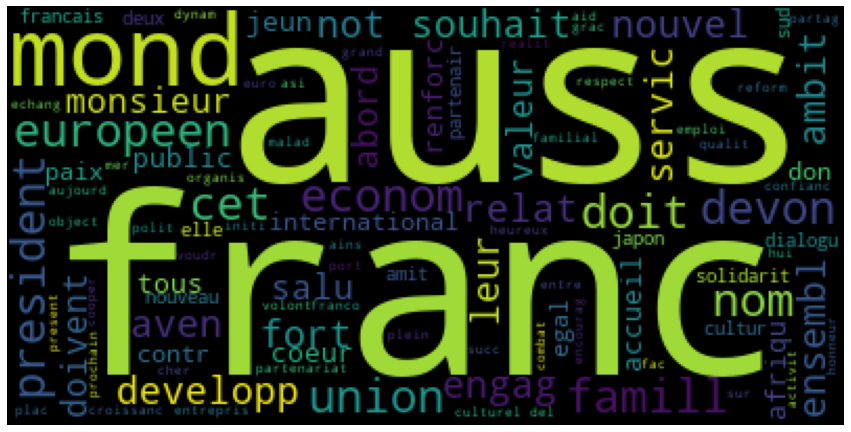

In [18]:
# Odds ratios
cv = CountVectorizer()
odds_ratio = compute_odd_ratio(X_preprocessed, Y, Vectorizer=cv)

print('Wordcloud pour les discours de Chirac')
visualize_class_wordcloud(odds_ratio, label = 1, n = 100, language = 'french')

Wordcloud pour les discours de Mittérand


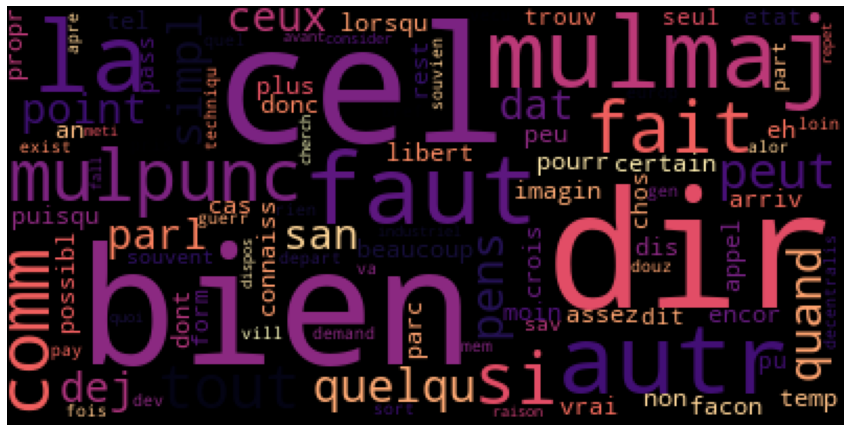

In [19]:
print('Wordcloud pour les discours de Mittérand')
visualize_class_wordcloud(odds_ratio, label = -1, n = 100, language = 'french')

### 3.5 Quelle est la distribution d'apparition des mots (Zipf)

Selon la loi de Zipf, dans une langue naturelle, les mots les plus fréquemment utilisés ont une fréquence d'utilisation beaucoup plus élevée que les mots les moins fréquemment utilisés. De plus, la fréquence relative d'utilisation des mots est inversement proportionnelle à leur rang dans la liste des mots classés par fréquence d'utilisation. Autrement dit, le deuxième mot le plus fréquemment utilisé aura une fréquence d'utilisation environ deux fois plus faible que le mot le plus fréquemment utilisé, le troisième mot aura une fréquence d'utilisation environ trois fois plus faible que le mot le plus fréquemment utilisé, et ainsi de suite.

La loi de Zipf peut être représentée par une courbe log-log, où la fréquence relative d'utilisation des mots est représentée sur l'axe des y, et leur rang sur l'axe des x. La courbe est généralement proche d'une droite, ce qui montre que la relation entre la fréquence d'utilisation et le rang est presque linéaire.

In [25]:
from collections import Counter

def get_most_common_words(corpus, vocabulary, num_words=100):
    vocabulary = set(vocabulary) ## Convert vocabulary to set so that the membership checking can be done in constant time
    words = []
    for text in corpus:
        words.extend([word for word in text.split() if word in vocabulary])
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

# get_most_common_words(X_train,vocabulaire)

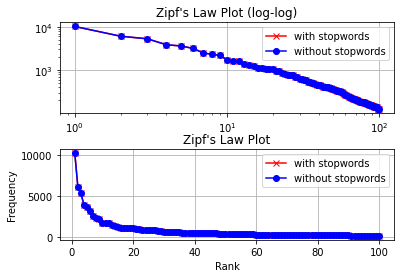

In [26]:
import matplotlib.pyplot as plt
import numpy as np

mcw_with_stopwords = get_most_common_words(X,vocabulaire) ## red color
mcw_without_stopwords = get_most_common_words(X,vocabulaire) ## blue color
    
# Plotting distribution of words before and after removal of stopwords
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
words = [word_count[0] for word_count in mcw_with_stopwords]
freqs = [word_count[1] for word_count in mcw_with_stopwords]
words2 = [word_count[0] for word_count in mcw_without_stopwords]
freqs2 = [word_count[1] for word_count in mcw_without_stopwords]
rank = np.arange(1, len(words)+1)
rank2 = np.arange(1, len(words)+1)
plt1, = ax1.loglog(rank, freqs, label = "with stopwords", color="red", marker="x") 
plt2, = ax1.loglog(rank2, freqs2, label = "without stopwords", color="blue", marker="o")
ax1.set_title("Zipf's Law Plot (log-log)")
ax1.legend(handles=[plt1, plt2],loc = "upper right")
ax1.grid(True)
plt1, = ax2.plot(rank, freqs, label = "with stopwords", color="red", marker="x") 
plt2, = ax2.plot(rank2, freqs2, label = "without stopwords", color="blue", marker="o")
ax2.set_title("Zipf's Law Plot")
ax2.grid(True)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend(handles=[plt1, plt2],loc = "upper right")
plt.subplots_adjust(hspace=0.4)
plt.show()

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# initialize CountVectorizer object
vectorizer = CountVectorizer()

# fit and transform the corpus into a document-term matrix
dtm = vectorizer.fit_transform(corpus)

# get the vocabulary (unique words in the corpus) and their counts
vocab = vectorizer.vocabulary_
word_counts = dtm.sum(axis=0)

# create a list of (word, count) tuples, sorted by count in descending order
word_freq = [(word, word_counts[0, idx]) for word, idx in vocab.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# print the 10 most frequent words
print(word_freq[:10])

[('franc', 985), ('plus', 921), ('tout', 756), ('cet', 706), ('mulmaj', 679), ('pay', 562), ('auss', 554), ('grand', 462), ('etre', 457), ('cel', 409)]


(-0.5, 399.5, 199.5, -0.5)

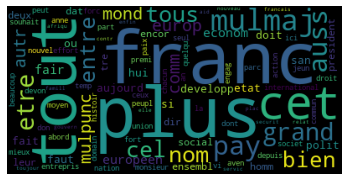

In [28]:
# Your code here
wordcloud = WordCloud(background_color='black', stopwords = stopwords_, max_words=100)
wordcloud.generate_from_frequencies(frequencies=dict(word_freq))

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

In [29]:

wordcloud_nstop = WordCloud(background_color='black', stopwords = [], max_words=100)
wordcloud_nstop = wordcloud.generate_from_frequencies(frequencies=dict(word_freq))

wordcloud_wstop = WordCloud(background_color='black', stopwords = stopwords_, max_words=100)
wordcloud_wstop = wordcloud.generate_from_frequencies(frequencies=dict(word_freq))


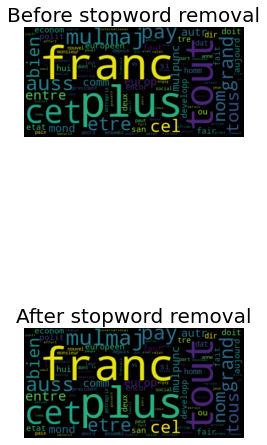

In [30]:
# Showing the word clouds side by side

fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 6))
ax1.imshow(wordcloud_nstop, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Before stopword removal", fontdict={'fontsize':20, 'y':1.1})
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_wstop, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("After stopword removal", fontdict={'fontsize':20, 'y':1.1})
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()

### 3.6 Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def get_top_ngrams(texts,ngram_range,topk=100):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    ngram_counts = dict(zip(feature_names, X.toarray().sum(axis=0)))
    top_k_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:topk]
    return top_k_ngrams

In [32]:
## Calculating the top 100 bigrams
top_100_bigrams = get_top_ngrams(X,(2,2))

## Calculating the top 100 trigrams
top_100_trigrams = get_top_ngrams(X,(3,3))

In [33]:
print("TOP 30 BIGRAMMES : ")
top_100_bigrams[:30]

TOP 30 BIGRAMMES : 


[('de la', 1704),
 ('la france', 708),
 ('et de', 674),
 ('aujourd hui', 390),
 ('dans le', 352),
 ('et la', 351),
 ('il faut', 320),
 ('qu il', 296),
 ('de nos', 281),
 ('de notre', 271),
 ('tous les', 261),
 ('dans la', 253),
 ('que nous', 253),
 ('vous avez', 250),
 ('nous avons', 237),
 ('et les', 234),
 ('monsieur le', 233),
 ('que vous', 229),
 ('que la', 220),
 ('dans les', 214),
 ('et des', 204),
 ('qui est', 201),
 ('et le', 195),
 ('et je', 192),
 ('pour la', 188),
 ('il est', 186),
 ('est pas', 182),
 ('le président', 178),
 ('ce que', 176),
 ('et qui', 173)]

On peut déjà remarquer que l'inclusion des bi-grammes dans le vocabulaire du corpus ajoute de la sémantique et du sens. Dans le cas où on utilise que des mots unaires.

## B.2.1. TF-IDF EMBEDDING :

Le TF-IDF (Term Frequency - Inverse Document Frequency) est une technique de traitement du langage naturel qui permet de transformer du texte en un vecteur de nombres. Le processus consiste à calculer un score TF-IDF pour chaque mot dans chaque document d'un corpus, où le score TF-IDF est défini comme le produit de la fréquence du terme (TF) et de l'inverse de la fréquence dans le corpus (IDF). La formule pour le score TF-IDF est donnée par :

$$\text{tf-idf}(t,d)=\text{tf}(t,d)×\text{idf}(t)$$

où $t$ est un terme (mot), $d$ est un document, $\text{tf}(t,d)$ est la fréquence du terme $t$ dans le document $d$ et $\text{idf}(t)$ est l'inverse de la fréquence du terme $t$ dans le corpus.

L'embedding TF-IDF consiste à utiliser la technique TF-IDF pour générer des embeddings de mots (représentations vectorielles de mots) à partir d'un corpus de documents. Ces embeddings peuvent ensuite être utilisés comme entrée pour un modèle de classification de texte.

Pour utiliser l'embedding TF-IDF avec la base de données IMDB (Internet Movie Database) qui contient des critiques de films, nous devons d'abord prétraiter les données en les nettoyant. Ensuite, nous pouvons utiliser la classe TfidfVectorizer du module scikit-learn pour générer les embeddings, et on va comparer les résultats obtenus avec un Count-Vectorizer.

**Il est important de noter que les termes qui apparaissent souvent dans un document donné, mais pas dans d'autres documents de l'ensemble de données, peuvent donc avoir un poids plus important pour la classification de sentiments.**



In [34]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
X_train_processed = text_processor(X_train, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the datasets for both tfidf embedding and count embeddings (for comparison)
tfidf = TfidfVectorizer()
cv = CountVectorizer()

odds_ratio_tfidf = compute_odd_ratio(X_train_processed,Y_train,Vectorizer=tfidf)
odds_ratio_count = compute_odd_ratio(X_train_processed,Y_train,Vectorizer=cv)


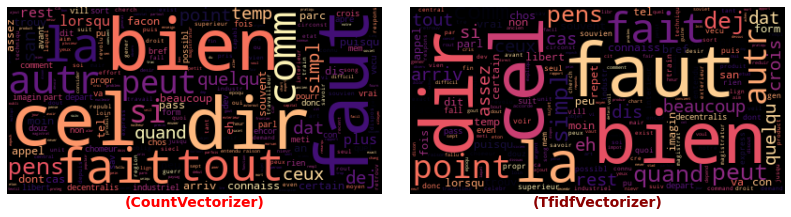

In [35]:
## Negative reviews wordcloud with count vectorizer
wordcloud_0_count = visualize_class_wordcloud(odds_ratio_count,-1,600,language='french',show=False)

## Negative reviews wordcloud with tf-idf vectorizer
wordcloud_0_tfidf = visualize_class_wordcloud(odds_ratio_tfidf,-1,600,language='french',show=False)

# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 20))
ax1.imshow(wordcloud_0_count, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("(CountVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0_tfidf, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("(TfidfVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'#8B0000'}, y = -0.1, weight='bold')
ax2.set_position([0.5, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


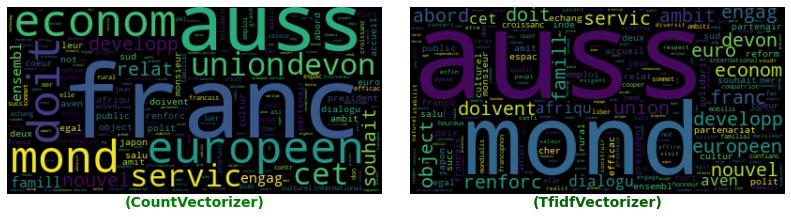

In [37]:
## Positive reviews wordcloud with count vectorizer
wordcloud_1_count = visualize_class_wordcloud(odds_ratio_count,1,600,language='english',show=False)

## Positive reviews wordcloud with tf-idf vectorizer
wordcloud_1_tfidf = visualize_class_wordcloud(odds_ratio_tfidf,1,600,language='english',show=False)

# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 20))
ax1.imshow(wordcloud_1_count, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("(CountVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_1_tfidf, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("(TfidfVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'#006400'}, y = -0.1, weight='bold')
ax2.set_position([0.5, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


### 3.8 Réduction de la taille du vocabulaire :

La réduction du vocabulaire peut améliorer les résultats, plus spécifiquement : 


* Ça peut aider à éviter le surapprentissage (overfitting) du modèle. Le surapprentissage se produit lorsque le modèle apprend à mémoriser les données d'entraînement plutôt que de généraliser à de nouvelles données. Si le vocabulaire est trop grand, il est possible que le modèle apprenne à mémoriser les mots spécifiques à l'ensemble d'entraînement, plutôt que d'apprendre à reconnaître les motifs généraux qui permettent de classifier les sentiments. En réduisant le vocabulaire, on peut réduire le risque de surapprentissage et améliorer la capacité du modèle à généraliser à de nouvelles données.

* Ça peut permettre d'améliorer la vitesse de traitement des données, ce qui peut être particulièrement important dans le cas de grandes bases de données. En effet, plus le vocabulaire est grand, plus le temps de calcul nécessaire pour traiter les données sera important. En réduisant le vocabulaire, on peut accélérer le traitement des données et rendre le modèle plus efficace.

In [38]:
# max_df: float (ratio) / integer(number) of document above which we remove the word)
# min_df: float (ratio) / integer(number) of document under which we remove the word)

min_df = 1             
max_df = 0.3
max_features=10000

## Initializing vectorizers
cv = CountVectorizer(min_df=min_df,max_df=max_df,max_features=max_features)
tfidf = TfidfVectorizer(min_df=min_df,max_df=max_df,max_features=max_features)

## pre-processing data by activating : no need to remove stopwords, max_df will take care of it
X_train_processed = text_processor(X_train, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the datasets for both tfidf embedding and count embeddings (for comparison)
odds_ratio_tfidf = compute_odd_ratio(X_train_processed,Y_train,Vectorizer=tfidf)
odds_ratio_count = compute_odd_ratio(X_train_processed,Y_train,Vectorizer=cv)

# Etape 04 : Modèles de Machine Learning

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
from tqdm import tqdm
import os
import time

import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

In [40]:
## big dataset preprocessing
X_train_processed = text_processor(X_train, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
X_embedded = TfidfVectorizer().fit_transform(X_train_processed)
print(len(X_train_processed))

6990


In [41]:
def batch_set(X_train,Y_train,data_size) :
    
    # select an equal number of positive and negative samples
    num_pos = int(data_size / 2)
    num_neg = int(data_size / 2)
    pos_indices = np.random.choice(np.where(Y_train == 1)[0], size = num_pos, replace=False)
    neg_indices = np.random.choice(np.where(Y_train == -1)[0], size = num_neg, replace=False)

    # select the remaining samples randomly
    remaining_indices = np.setdiff1d(np.arange(X_train.shape[0]), np.concatenate([pos_indices, neg_indices]))
    remaining_indices = np.random.choice(remaining_indices, size = data_size - num_pos - num_neg, replace=False)

    # combine the selected indices and shuffle them
    selected_indices = np.concatenate([pos_indices, neg_indices, remaining_indices])
    np.random.shuffle(selected_indices)

    # extract the corresponding samples from X_train and Y_train
    X_batch = X_train[selected_indices]
    Y_batch = Y_train[selected_indices]

    return X_batch, Y_batch

In [54]:
train_sizes = [100, 250, 500, 1000, 1500, 2000, 2500]

training_times_lr  =  []
training_times_svm =  []
training_times_nb  =  []

for size in train_sizes:
    lr_clf = LogisticRegression(max_iter=1000)
    nb_clf = MultinomialNB()
    svm_clf = LinearSVC(max_iter=1000)
    X_batch,y_batch = batch_set(X_embedded,Y_train,size)
    ## Logistic Regression
    start = time.time()
    lr_clf.fit(X_batch,y_batch)
    training_times_lr.append((time.time()-start)*10e3)
    ## Naive Bayes
    start = time.time()
    nb_clf.fit(X_batch,y_batch)
    training_times_nb.append((time.time()-start)*10e3)
    ## SVM
    start = time.time()
    svm_clf.fit(X_batch,y_batch)
    training_times_svm.append((time.time()-start)*10e3)

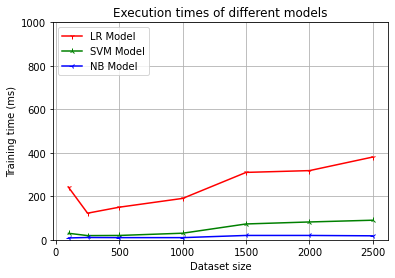

In [55]:
import matplotlib.pyplot as plt

plt1, = plt.plot(train_sizes, training_times_lr, label = "LR Model", color="red", marker="1") 
plt2, = plt.plot(train_sizes, training_times_svm, label = "SVM Model", color="green", marker="2")
plt3, = plt.plot(train_sizes, training_times_nb, label = "NB Model", color="blue", marker="3") 

plt.title("Execution times of different models")
plt.legend(handles=[plt1, plt2, plt3], loc = "upper left")
plt.ylim(0, 1000)
plt.ylim(0, 1000)
plt.grid(True)
plt.xlabel("Dataset size")
plt.ylabel("Training time (ms)")
plt.show()

**Commentaires :**

La vitesse à laquelle un modèle d'apprentissage automatique fonctionne dépend de nombreuses variables, notamment de la taille de l'ensemble de données, du nombre de caractéristiques et de la complexité du modèle. Cependant, en général, **Naive Bayes** est perçu comme l'un des algorithmes de classification les plus rapides, suivi par la **régression logistique** et le **SVM linéaire**.

Naive Bayes est notamment rapide car il s'agit d'un modèle probabiliste simple qui ne nécessite pas d'optimisation itérative comme la régression logistique ou le SVM. Il évalue directement les probabilités a posteriori des classes en fonction des caractéristiques en utilisant le théorème de Bayes et peut ainsi créer rapidement des prédictions.

La régression logistique et le SVM linéaire sont des modèles plus polyvalents qui utilisent des algorithmes d'optimisation pour déterminer les poids optimaux des caractéristiques. En général, le SVM peut être plus lent que la régression logistique car il implique la résolution d'un problème de programmation quadratique pour localiser l'hyperplan de séparation. Cependant, la régression logistique et le SVM linéaire sont généralement plus rapides que les modèles plus complexes comme les arbres de décision, les forêts aléatoires ou les réseaux neuronaux.

Il est important de noter que la vitesse comparative de ces modèles peut varier en fonction de l'implémentation spécifique, de la taille et de la complexité de l'ensemble de données, et du problème spécifique que vous tentez de résoudre. Par conséquent, il est suggéré de réaliser des expériences et de comparer les performances de différents modèles pour un problème particulier, plutôt que de se fier uniquement à leur vitesse relative.


---

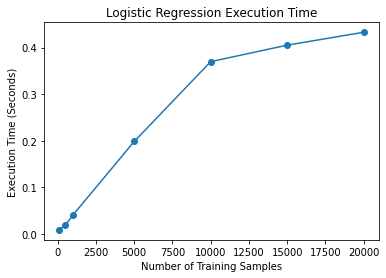

In [56]:
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Define a function to train a logistic regression model and measure the execution time
def train_logistic_regression(X_train, y_train):
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    model = LogisticRegression()
    start_time = time.time()
    model.fit(X_train_vectorized, y_train)
    end_time = time.time()
    return end_time - start_time

# Measure the execution time for different numbers of training samples
num_samples = [100, 500, 1000, 5000, 10000, 15000, 20000]
execution_times = []
for n in num_samples:
    execution_time = train_logistic_regression(X_train[:n], Y_train[:n])
    execution_times.append(execution_time)

# Plot the execution time as a function of the number of training samples
plt.plot(num_samples, execution_times, 'o-')
plt.xlabel('Number of Training Samples')
plt.ylabel('Execution Time (Seconds)')
plt.title('Logistic Regression Execution Time')
plt.show()


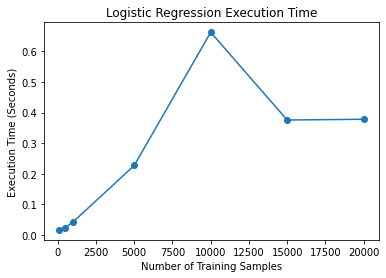

In [57]:
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Define a function to train a logistic regression model and measure the execution time
def train_logistic_regression(X_train, y_train):
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    model = LogisticRegression()
    start_time = time.time()
    model.fit(X_train_vectorized, y_train)
    end_time = time.time()
    return end_time - start_time

# Measure the execution time for different numbers of training samples
num_samples = [100, 500, 1000, 5000, 10000, 15000, 20000]
execution_times = []
for n in num_samples:
    execution_time = train_logistic_regression(X_train[:n], Y_train[:n])
    execution_times.append(execution_time)

# Plot the execution time as a function of the number of training samples
plt.plot(num_samples, execution_times, 'o-')
plt.xlabel('Number of Training Samples')
plt.ylabel('Execution Time (Seconds)')
plt.title('Logistic Regression Execution Time')
plt.show()


In [59]:
# Représentation vectorielle des données présidentielles
vectorizer_pres = CountVectorizer()
xtrain = vectorizer_pres.fit_transform(X_train)
vocabulaire_pres = vectorizer_pres.get_feature_names_out()

In [60]:
############################################## SANS VALIDATION CROISEE  ################################################

# Création modèle, phase d'apprentissage
clf = LinearSVC()
clf.fit(xtrain, Y_train)

# Prédictions sur quelques données
yhat = clf.predict(xtrain[-10:])
y = Y_train[-10:]

print('Prédictions:', yhat)
print('Vraies classes', y)

print('Score sur les données d\'entraînement:', clf.score(xtrain, Y_train) )
print('Vecteur de poids du SVM:', clf.coef_)

Prédictions: [1 1 1 1 1 1 1 1 1 1]
Vraies classes [1 1 1 1 1 1 1 1 1 1]
Score sur les données d'entraînement: 0.9982832618025751
Vecteur de poids du SVM: [[ 0.94099079  0.11566633  0.03611563 ... -0.18785744  0.0429078
   0.        ]]


In [61]:
##################################### EN VALIDATION CROISEE, KFOLD, SHUFFLE = FALSE #######################################

from sklearn.model_selection import KFold, cross_val_score

# Création modèle, phase d'apprentissage
clf = LinearSVC()

# Prédictions sur quelques données
kfold = KFold(n_splits=5, shuffle=False)
scores_cv = cross_val_score(clf, xtrain, Y_train, cv=kfold)

print('Score sur les données d\'entraînement:', scores_cv )

Score sur les données d'entraînement: [0.8111588  0.78898426 0.80758226 0.84334764 0.8583691 ]


In [62]:
##################################### EN VALIDATION CROISEE, KFOLD, SHUFFLE = TRUE #######################################

from sklearn.model_selection import KFold, cross_val_score

# Création modèle, phase d'apprentissage
clf = LinearSVC()

# Prédictions sur quelques données
kfold = KFold(n_splits=5, shuffle=True)
scores_cv = cross_val_score(clf, xtrain, Y_train, cv=kfold)

print('Score sur les données d\'entraînement:', scores_cv )

Score sur les données d'entraînement: [0.83547926 0.8397711  0.83834049 0.82832618 0.83619456]


In [63]:
################################ EN VALIDATION CROISEE, STRATIFIEDKFOLD, SHUFFLE = FALSE ##################################

from sklearn.model_selection import StratifiedKFold, cross_val_score

# Par défaut cross_val_score utilise déjà StratifiedKFold, mais on veut mettre le paramètre shuffle à False

# Création modèle, phase d'apprentissage
clf = LinearSVC()

# Prédictions sur quelques données
strat_kfold = StratifiedKFold(n_splits=5, shuffle=False)
scores_cv = cross_val_score(clf, xtrain, Y_train, cv=strat_kfold)

print('Score sur les données d\'entraînement:', scores_cv )

Score sur les données d'entraînement: [0.8204578  0.79828326 0.82761087 0.82546495 0.83190272]


In [64]:
################################ EN VALIDATION CROISEE, STRATIFIEDKFOLD, SHUFFLE = TRUE ##################################

# Par défaut cross_val_score utilise déjà StratifiedKFold, mais on veut mettre le paramètre shuffle à True

# Création modèle, phase d'apprentissage
clf = LinearSVC()

# Prédictions sur quelques données
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores_cv = cross_val_score(clf, xtrain, Y_train, cv=strat_kfold)

print('Score sur les données d\'entraînement:', scores_cv )


Score sur les données d'entraînement: [0.8583691  0.84978541 0.84334764 0.83404864 0.82403433]


In [65]:
########################################## MODELE NAIVE BAYES (MULTINOMIAL) ##########################################
# Création modèle, phase d'apprentissage
clf = MultinomialNB()
clf.fit(xtrain, Y_train)

# Prédictions sur quelques données
yhat = clf.predict(xtrain[-10:])
y = Y_train[-10:]

print('Prédictions:', yhat)
print('Vraies classes', y)

print('Score sur les données d\'entraînement:', clf.score(xtrain, Y_train) )

Prédictions: [1 1 1 1 1 1 1 1 1 1]
Vraies classes [1 1 1 1 1 1 1 1 1 1]
Score sur les données d'entraînement: 0.9271816881258942


In [66]:
############################################# MODELE REGRESSION LOGISTIQUE #############################################

# Création modèle, phase d'apprentissage
clf = LogisticRegression()
clf.fit(xtrain, Y_train)

# Prédictions sur quelques données
yhat = clf.predict(xtrain[-10:])
y = Y_train[-10:]

print('Prédictions:', yhat)
print('Vraies classes', y)

print('Score sur les données d\'entraînement:', clf.score(xtrain, Y_train) )
print('Vecteur de poids pour la régression logistique:', clf.coef_)

Prédictions: [1 1 1 1 1 1 1 1 1 1]
Vraies classes [1 1 1 1 1 1 1 1 1 1]
Score sur les données d'entraînement: 0.9650929899856938
Vecteur de poids pour la régression logistique: [[ 1.39275471  0.17674081  0.03732513 ... -0.25235929  0.1764227
   0.09041352]]


### Application d'un gridSearchcv sur le corpus

In [42]:
import warnings
warnings.filterwarnings("ignore")

### GridSearch Class

In [25]:
from sklearn.model_selection import ParameterGrid

# Définition de la fonction GridSearch

class GridSearch:
    """ Classe pour l'optimisation de paramètres par GridSearch.
    """
    def __init__(self, datax, datay, params):
        """ Constructeur de la classe GridSearch.
            @param datax: list(str), corpus de textes
            @param datay: list(int), classes correspondantes
            @param model: classifieur par encore entraîné
            @params: dict(str:object), dictionnaire des paramètres à tester et des valeurs qu'elles peuvent prendre
        """
        # Initialisation des scores ainsi que des paramètres correspondant
        self.scores = []
        self.params = []
        
        processing_params = list( ParameterGrid(params['processing']) )
        vectorizer_params = list( ParameterGrid(params['vectorizer']) )
        cv_params = list( ParameterGrid(params['cross_val']) )
        
        print('\n{} combinaisons de paramètres à tester...' . format( len(processing_params) * len(vectorizer_params) * len(cv_params) * 3 ))
        
        # Liste des différents modèles à tester
        classes = [ LinearSVC, MultinomialNB, LogisticRegression ]
        
        # Compteur itérations pour affichage dans le log
        i = 0
        
        for proc_grid in processing_params:
            # Pré-traitement du corpus selon les paramètres choisis
            processed_datax = text_processor(datax, **proc_grid)
            
            for func in classes:
                if func != MultinomialNB:
                    for C in params['cross_val']['C']:
                        # Pour chaque paramètre de régularisation
                        model = func( C = C )
                        
                        for vec_grid in vectorizer_params:
                            
                            # Représentation sous forme vectorielle
                            vectorizer = vec_grid['type'](ngram_range=vec_grid['ngram_range'])
                            X = vectorizer.fit_transform(processed_datax)

                            # Cross-validation
                            strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                            scores_cv = np.mean( cross_val_score(model, X, datay, cv=strat_kfold, scoring=['f1', 'accuracy']) )
                            print('Iter {} : model: {}, vectorizer: {}, params: {}, C: {} --> {}' .format(str(i), str(model), str(vec_grid), str(proc_grid), str(C), str(scores_cv)) )
                            
                            self.scores.append(scores_cv)
                            self.params.append((model, vec_grid, proc_grid, C))
                            i += 1
                else:
                    model = func()
                    
                    for vec_grid in vectorizer_params:
                            
                        # Représentation sous forme vectorielle
                        vectorizer = vec_grid['type'](ngram_range=vec_grid['ngram_range'])
                        X = vectorizer.fit_transform(processed_datax)
                            
                        model.fit(X, datay)

                        # Cross-validation
                        strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                        scores_cv = np.mean( cross_val_score(model, X, datay, cv=strat_kfold, scoring='f1') )
                        print('Iter {} : model: {}, vectorizer: {}, params: {} -> {}' .format(str(i), str(model), str(vec_grid), str(proc_grid), str(scores_cv)) )
                        
                        self.scores.append(scores_cv)
                        self.params.append((str(model), str(vec_grid), str(proc_grid)))
                        i += 1
                    

In [26]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

class BatchGridSearch:
    """ Classe pour l'optimisation de paramètres par GridSearch.
    """
    def __init__(self, datax, datay, params, params_filename='params.txt'):
        """ Constructeur de la classe GridSearch.
            Permet d'écrire dans un fichier param_filename toutes les combinaisons de paramètres à tester.
            @param datax: list(str), corpus de textes
            @param datay: list(int), classes correspondantes
            @params params: dict(str:object), dictionnaire des paramètres à tester et des valeurs qu'elles peuvent prendre
            @params_filename: str, fichier dans lequel on veut écrire la liste de nos paramètres
        """
        self.datax = datax
        self.datay = datay
        self.params = params
        self.params_filename = params_filename
        
        # Grilles de paramètres à tester
        processing_params = list( ParameterGrid(params['processing']) )
        vectorizer_params = list( ParameterGrid(params['vectorizer']) )
        model_params = list( ParameterGrid(params['model']) )
        cv_params = list( ParameterGrid(params['cross_val']) )
        
        # Paramètre du nombre de combinaisons au total
        self.n_combs_ = len(processing_params) * len(model_params) * len(vectorizer_params) * len(cv_params)

        # Ecriture dans un fichier
        with open(params_filename, 'w') as file:
            for processing in processing_params:
                for model in model_params:
                    for vectorizer in vectorizer_params:
                        for cv in cv_params:
                            params = {'processing' : processing, 'vectorizer': vectorizer, 'model': model, 'cross_val': cv}
                            file.write(str(params) + '\n')
        
    
    def compute_batch(self, from_, to_):
        """ Permet d'appliquer la cross-validation sur un batch de la grille de paramètres. La fonction crée un fichier de nom
            'out_{from_}_to_{to_}.txt' dans lequel chaque ligne contient l'indice de la ligne correspondante et le score du
            modèle testé en cross-validation. Les paramètres utilisés sont ceux allant de la ligne from_ à la ligne to_ dans le fichier nommé 
            self.params_filename.
            @params from_: int, indice de la ligne de départ du batch de paramètres à tester dans params_filename
            @param to_: int, indice de la ligne de fin de batch (comprise)
        """        
        # Récupération des paramètres du batch à tester
        with open(self.params_filename, 'r') as file:
            params_grid = file.readlines()
            for i in range(len(params_grid)):
                params_grid[i] = re.sub("<class 'sklearn.feature_extraction.text.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.svm.classes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.svm._classes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.naive_bayes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.linear_model.logistic.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.linear_model._logistic.([A-Za-z]*)'>", r'\1', params_grid[i])
                
                params_grid[i] = eval( params_grid[i].strip('\n') )
                #params_grid[i]['vectorizer']['type'] = eval( params_grid[i]['vectorizer']['type'] )
    
        print('\n{} combinaisons de paramètres à tester...' . format( to_ - from_ + 1 ))
        
        # Nom du fichier de sortie
        out_filename = 'out_' + str(from_) + '_to_' + str(to_) + '.txt'
        
        # Initialisation du dictionnaire pour la conversion en DataFrame
        df = dict()
        
        with open(out_filename, 'w') as out_file:

            for i in tqdm(range(from_, to_+1)):
                
                params = params_grid[i]
                
                # Pré-traitement du corpus selon les paramètres choisis
                processed_datax = text_processor(self.datax, **params['processing'])
                
                # Initialisation du modèle
                func = params['model']['m']
                if func != MultinomialNB:
                    model = func( C = params['cross_val']['C'] )
                else:
                    model = func()
                    
                # Représentation sous forme vectorielle
                vectorizer = params['vectorizer']['type'](ngram_range=params['vectorizer']['ngram_range'])
                X = vectorizer.fit_transform(processed_datax)

                # Cross-validation
                strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                scores = cross_validate(model, X, self.datay, cv=strat_kfold, scoring = ['accuracy','f1','roc_auc'])
                accuracy = np.mean( scores['test_accuracy'] )
                f1 = np.mean( scores['test_f1'] )
                roc_auc = np.mean( scores['test_roc_auc'] )
                        
                # Ecriture du score dans le fichier de sortie
                out_file.write('{} {} {} {}\n'.format(i, accuracy, f1, roc_auc))
                
                # Ecriture dans un dictionnaire pour l'affichage DataFrame
                line = params
                line['model']['m'] = line['model']['m'].__name__
                line['vectorizer']['type'] = line['vectorizer']['type'].__name__
                
                df[i] = [ i for k, v in line.items() for i in v.values() ]
                df[i].append(accuracy)
        
        # Affichage de sortie
        print('\n*** Fin de traitement, voir le fichier {} ***'.format(out_filename))
        
        # Affichage DataFrame Pandas
        return pd.DataFrame.from_dict(df, orient='index', columns=['language', 'select line', 'lowercase', 'no number', 'no punctuation', 'no stopwords', 'normalize', 'stemming', 'ngram', 'vectorizer', 'model', 'regularization factor', 'score'])

In [27]:
# Lecture des scores (accuracy, f1) pour chaque combinaison de paramètres par BatchGridSearch

def load_scores_df(params_file, scores_files, scores_names):
    """ Lit les fichiers params_files des paramètres et la liste de fichiers dans scores_files, et renvoie les
        scores associés à chaque combinaison sous la forme d'un DataFrame pandas.
        @param params_file: str, nom du fichier contenant toutes les combinaisons de paramètres testées
        @param scores_files: list(str), liste des fichiers contenant les scores obtenus par combinaison
        @param scores_names: list(str), liste des noms des scores
    """
    with open(params_file,'r') as file:
    
        lines = file.readlines()
        data = [['Language','Line','Lower','Remove digit','Remove punctuation','Remove stopwords','Normalize','Stemming','N-gram range','Vectorizer','Model','C','Accuracy score','F1 score', 'ROC-AUC score']]
        
        # Mappings des vectorizers et modèles
        vmap = { CountVectorizer : 'Counter', TfidfVectorizer : 'Tf-Idf' }
        mmap = { LinearSVC : 'Linear SVC', LogisticRegression : 'Logistic Regression', MultinomialNB : 'Naive Bayes' }
        
        for i in range(len(lines)):
            line = lines[i].strip('\n')
            line = re.sub("<class 'sklearn.feature_extraction.text.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.svm.classes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.svm._classes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.naive_bayes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.linear_model.logistic.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.linear_model._logistic.([A-Za-z]*)'>", r'\1', line)
            params = eval(line)

            processing = params['processing']
            vectorizer = params['vectorizer']
            model = params['model']
            cross_val = params['cross_val']
            data.append([processing['language'], processing['line'], processing['lowercase'], processing['no_num'], processing['no_punc'], processing['no_stopwords'], processing['norm'], processing['stemming'], vectorizer['ngram_range'], vmap[vectorizer['type']], mmap[model['m']], cross_val['C']])
    
    for score_file in scores_files:
        with open(score_file,'r') as file:
            lines = file.readlines()
            
            for line in lines:
                i, accuracy, f1, roc_auc = line.split()
                data[int(i)+1] += [float(accuracy), float(f1), float(roc_auc)]
    
    return pd.DataFrame(data[1:], columns=data[0])

In [28]:
# paramètres présidents: 3168 combinaisons
params = {"processing": { "language": ['french'],
                          "line": [None],
                          "no_punc": [True],
                          "no_num": [True],
                          "lowercase": [False,True],
                          "norm": [False,True],
                          "no_stopwords": [False, True],
                          "stemming": [False, True] },
          "vectorizer": {"type": [ CountVectorizer, TfidfVectorizer ], "ngram_range": [(1,1),(1,2),(2,2)]},
          "model": {"m": [ LinearSVC, MultinomialNB, LogisticRegression ] },
          "cross_val": { "C": [ 1 if i == 0 else i * 10 for i in range(5) ] }
         }

In [29]:
bgs = BatchGridSearch(X_train, Y_train, params, 'test.txt')
print('{} combinaisaisons de paramètres à tester' . format(bgs.n_combs_))

1440 combinaisaisons de paramètres à tester


---

## Campagne d'experiences

In [92]:
import time

t1 = time.time()
df = bgs.compute_batch(0,199)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


200 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:10<00:00,  3.65s/it]


*** Fin de traitement, voir le fichier out_0_to_199.txt ***
Temps d'exécution: 730.6183161735535 s


In [93]:
import time

t1 = time.time()
df = bgs.compute_batch(200,299)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:27<00:00,  3.27s/it]


*** Fin de traitement, voir le fichier out_200_to_299.txt ***
Temps d'exécution: 327.6207649707794 s


In [94]:
import time

t1 = time.time()
df = bgs.compute_batch(300,399)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:46<00:00,  3.47s/it]


*** Fin de traitement, voir le fichier out_300_to_399.txt ***
Temps d'exécution: 346.9788565635681 s


In [95]:
import time

t1 = time.time()
df = bgs.compute_batch(400,499)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.67s/it]


*** Fin de traitement, voir le fichier out_400_to_499.txt ***
Temps d'exécution: 366.8098392486572 s


In [96]:
import time

t1 = time.time()
df = bgs.compute_batch(500,599)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.18s/it]


*** Fin de traitement, voir le fichier out_500_to_599.txt ***
Temps d'exécution: 318.4793276786804 s


In [97]:
import time

t1 = time.time()
df = bgs.compute_batch(600,699)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.55s/it]


*** Fin de traitement, voir le fichier out_600_to_699.txt ***
Temps d'exécution: 354.786630153656 s


In [98]:
import time

t1 = time.time()
df = bgs.compute_batch(700,799)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:53<00:00,  3.54s/it]


*** Fin de traitement, voir le fichier out_700_to_799.txt ***
Temps d'exécution: 354.01074051856995 s


In [99]:
import time

t1 = time.time()
df = bgs.compute_batch(800,899)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:49<00:00,  4.70s/it]


*** Fin de traitement, voir le fichier out_800_to_899.txt ***
Temps d'exécution: 469.7384693622589 s


In [100]:
import time

t1 = time.time()
df = bgs.compute_batch(900,999)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:43<00:00,  2.84s/it]


*** Fin de traitement, voir le fichier out_900_to_999.txt ***
Temps d'exécution: 283.9728353023529 s


In [101]:
import time

t1 = time.time()
df = bgs.compute_batch(1000,1199)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


200 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:05<00:00,  3.63s/it]


*** Fin de traitement, voir le fichier out_1000_to_1199.txt ***
Temps d'exécution: 725.3468644618988 s


In [102]:
import time

t1 = time.time()
df = bgs.compute_batch(1200,1299)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


100 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:12<00:00,  3.13s/it]


*** Fin de traitement, voir le fichier out_1200_to_1299.txt ***
Temps d'exécution: 313.11749291419983 s


In [104]:
import time

t1 = time.time()
df = bgs.compute_batch(1300,1439)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


140 combinaisons de paramètres à tester...


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [08:36<00:00,  3.69s/it]


*** Fin de traitement, voir le fichier out_1300_to_1439.txt ***
Temps d'exécution: 516.5587482452393 s


---

In [49]:
params_file  = 'test.txt'
scores_files = [ 'Results/out_0_to_199.txt' ]
scores_names = [ 'accuracy', 'f1', 'roc_auc' ]

scores_df = load_scores_df(params_file, scores_files, scores_names)
scores_df

,Language,Line,Lower,Remove digit,Remove punctuation,Remove stopwords,Normalize,Stemming,N-gram range,Vectorizer,Model,C,Accuracy score,F1 score,ROC-AUC score
0,french,None,False,True,True,False,False,False,"(1, 1)",Counter,Linear SVC,1,0.839771,0.901636,0.833930
1,french,None,False,True,True,False,False,False,"(1, 1)",Counter,Linear SVC,10,0.822031,0.888982,0.813209
2,french,None,False,True,True,False,False,False,"(1, 1)",Counter,Linear SVC,20,0.819313,0.887437,0.809562
3,french,None,False,True,True,False,False,False,"(1, 1)",Counter,Linear SVC,30,0.817454,0.886142,0.801798
4,french,None,False,True,True,False,False,False,"(1, 1)",Counter,Linear SVC,40,0.817310,0.886069,0.801996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,french,None,True,True,True,True,True,True,"(2, 2)",Tf-Idf,Logistic Regression,1,NaN,NaN,NaN
1436,french,None,True,True,True,True,True,True,"(2, 2)",Tf-Idf,Logistic Regression,10,NaN,NaN,NaN
1437,french,None,True,True,True,True,True,True,"(2, 2)",Tf-Idf,Logistic Regression,20,NaN,NaN,NaN
1438,french,None,True,True,True,True,True,True,"(2, 2)",Tf-Idf,Logistic Regression,30,NaN,NaN,NaN


In [30]:
def read_param_file(file_path, index):
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i == index - 1:
                l = line.strip('\n')
                l = re.sub("<class 'sklearn.feature_extraction.text.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.svm.classes.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.svm._classes.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.naive_bayes.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.linear_model.logistic.([A-Za-z]*)'>", r'\1', l)
                l = re.sub("<class 'sklearn.linear_model._logistic.([A-Za-z]*)'>", r'\1', l)
                params = eval(l)
                return params
    raise IndexError('Index out of range')

read_param_file("test.txt",1)

{'processing': {'language': 'french',
  'line': None,
  'lowercase': False,
  'no_num': True,
  'no_punc': True,
  'no_stopwords': False,
  'norm': False,
  'stemming': False},
 'vectorizer': {'ngram_range': (1, 1),
  'type': sklearn.feature_extraction.text.CountVectorizer},
 'model': {'m': sklearn.svm._classes.LinearSVC},
 'cross_val': {'C': 1}}

In [31]:
models = pd.read_csv('out_0_to_1439.txt', delimiter=' ', header=None, names=['ID', 'Accuracy', 'F1 score', 'Roc_auc'])
models

,ID,Accuracy,F1 score,Roc_auc
0,0,0.839771,0.901636,0.833930
1,1,0.822031,0.888982,0.813209
2,2,0.819313,0.887437,0.809562
3,3,0.817454,0.886142,0.801798
4,4,0.817310,0.886069,0.801996
...,...,...,...,...
1435,1435,0.799285,0.888447,0.763039
1436,1436,0.800858,0.889155,0.769617
1437,1437,0.801860,0.889597,0.766248
1438,1438,0.801860,0.889527,0.762710


In [32]:
sorted_by_accuracy = models.sort_values(by='Accuracy', ascending=False)
sorted_by_accuracy

,ID,Accuracy,F1 score,Roc_auc
106,106,0.861946,0.918055,0.876216
1007,1007,0.861803,0.918009,0.873863
826,826,0.861660,0.918107,0.874763
108,108,0.861660,0.917790,0.875132
286,286,0.861373,0.917983,0.873705
...,...,...,...,...
1133,1133,0.588269,0.679540,0.732799
1130,1130,0.587983,0.678427,0.734322
1313,1313,0.586838,0.677376,0.736117
1310,1310,0.586838,0.677384,0.735009


In [53]:
sorted_by_f1score = models.sort_values(by='F1 score', ascending=False)
sorted_by_f1score

,ID,Accuracy,F1 score,Roc_auc
826,826,0.861660,0.918107,0.874763
106,106,0.861946,0.918055,0.876216
1007,1007,0.861803,0.918009,0.873863
286,286,0.861373,0.917983,0.873705
108,108,0.861660,0.917790,0.875132
...,...,...,...,...
1133,1133,0.588269,0.679540,0.732799
1130,1130,0.587983,0.678427,0.734322
1310,1310,0.586838,0.677384,0.735009
1313,1313,0.586838,0.677376,0.736117


In [54]:
sorted_by_rocauc = models.sort_values(by='Roc_auc', ascending=False)
sorted_by_rocauc

,ID,Accuracy,F1 score,Roc_auc
889,889,0.856223,0.915936,0.881953
799,799,0.853791,0.914668,0.879063
15,15,0.848784,0.911972,0.878819
825,825,0.856509,0.916154,0.878637
168,168,0.856080,0.916021,0.878578
...,...,...,...,...
1373,1373,0.810730,0.892340,0.726910
1194,1194,0.816023,0.895381,0.726461
1193,1193,0.812876,0.893698,0.726328
1283,1283,0.811159,0.892824,0.722846


In [55]:
read_param_file("test.txt",106)

{'processing': {'language': 'french',
  'line': None,
  'lowercase': False,
  'no_num': True,
  'no_punc': True,
  'no_stopwords': False,
  'norm': False,
  'stemming': True},
 'vectorizer': {'ngram_range': (1, 2),
  'type': sklearn.feature_extraction.text.TfidfVectorizer},
 'model': {'m': sklearn.svm._classes.LinearSVC},
 'cross_val': {'C': 1}}

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


tfidf = TfidfVectorizer(ngram_range=(1,2))

X_train_processed = text_processor(X_train, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=False, no_stopwords=False, norm=False, stemming=True)
X_train_embedded = tfidf.fit_transform(X_train_processed)
X_test_processed = text_processor(X_test, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=False, no_stopwords=False, norm=False, stemming=True)
X_test_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)

svm_clf = LinearSVC(C=1)
svm_clf.fit(X_train_embedded, Y_train)

y_pred = svm_clf.predict(X_test_embedded)


print('Accuracy score : ', accuracy_score(Y_test, y_pred))
print('F1 Score : ', f1_score(Y_test, y_pred))
print('ROC AUC Score : ', roc_auc_score(Y_test, y_pred))

Accuracy score :  0.8649885583524027
F1 Score :  0.9198913781398507
ROC AUC Score :  0.7284676614181161


In [57]:
read_param_file("test.txt",826)

{'processing': {'language': 'french',
  'line': None,
  'lowercase': True,
  'no_num': True,
  'no_punc': True,
  'no_stopwords': False,
  'norm': False,
  'stemming': True},
 'vectorizer': {'ngram_range': (1, 2),
  'type': sklearn.feature_extraction.text.TfidfVectorizer},
 'model': {'m': sklearn.svm._classes.LinearSVC},
 'cross_val': {'C': 1}}

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


tfidf = TfidfVectorizer(ngram_range=(1,2))

X_train_processed = text_processor(X_train, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=False, norm=False, stemming=True)
X_train_embedded = tfidf.fit_transform(X_train_processed)
X_test_processed = text_processor(X_test, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=False, norm=False, stemming=True)
X_test_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)

svm_clf = LinearSVC(C=1)
svm_clf.fit(X_train_embedded, Y_train)

y_pred = svm_clf.predict(X_test_embedded)


print('Accuracy score : ', accuracy_score(Y_test, y_pred))
print('F1 Score : ', f1_score(Y_test, y_pred))
print('ROC AUC Score : ', roc_auc_score(Y_test, y_pred))

Accuracy score :  0.8649885583524027
F1 Score :  0.9198913781398507
ROC AUC Score :  0.7284676614181161


In [59]:
read_param_file("test.txt",1007)

{'processing': {'language': 'french',
  'line': None,
  'lowercase': True,
  'no_num': True,
  'no_punc': True,
  'no_stopwords': False,
  'norm': True,
  'stemming': True},
 'vectorizer': {'ngram_range': (1, 2),
  'type': sklearn.feature_extraction.text.TfidfVectorizer},
 'model': {'m': sklearn.svm._classes.LinearSVC},
 'cross_val': {'C': 10}}

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


tfidf = TfidfVectorizer(ngram_range=(1,2))

X_train_processed = text_processor(X_train, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=False, norm=True, stemming=True)
X_train_embedded = tfidf.fit_transform(X_train_processed)
X_test_processed = text_processor(X_test, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=False, norm=False, stemming=True)
X_test_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)

svm_clf = LinearSVC(C=10)
svm_clf.fit(X_train_embedded, Y_train)

y_pred = svm_clf.predict(X_test_embedded)


print('Accuracy score : ', accuracy_score(Y_test, y_pred))
print('F1 Score : ', f1_score(Y_test, y_pred))
print('ROC AUC Score : ', roc_auc_score(Y_test, y_pred))

Accuracy score :  0.8432494279176201
F1 Score :  0.9055172413793103
ROC AUC Score :  0.720567356397644


In [61]:
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=10000)

X_train_processed = text_processor(X_train, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=False, no_stopwords=False, norm=False, stemming=True)
X_train_embedded = tfidf.fit_transform(X_train_processed)
X_test_processed = text_processor(X_test, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=False, no_stopwords=False, norm=False, stemming=True)
X_test_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)


In [35]:
from sklearn.pipeline import Pipeline

# define class weights
w = {-1:1402, 1:5588}

lr_clf = LogisticRegression(C=1, class_weight=w, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

lr_clf.fit(X_train_embedded, Y_train)

y_pred = lr_clf.predict(X_test_embedded)

print('Accuracy score : ', accuracy_score(Y_test, y_pred))
print('F1 Score : ', f1_score(Y_test, y_pred))
print('ROC AUC Score : ', roc_auc_score(Y_test, y_pred))

Accuracy score :  0.8638443935926774
F1 Score :  0.9199192462987887
ROC AUC Score :  0.7094382310644574


In [36]:
with open("President_eval.txt", 'r', encoding='utf-8') as f:
    paragraphs = f.read().split('\n')
    
tmp = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]
X_test_server = []
for p in tmp:
    a = " ".join([m for m in p.split()[1:-1]])
    X_test_server.append(a)
    
np.array(X_test_server).shape

(27162,)

In [37]:
print(len(X_test_server))
print('---')
print(X_test_server[0])
print('---')
print(X_test_server[-1])

27162
---
En répondant à votre invitation, en effectuant cette première visite d'Etat d'un Président français en Algérie depuis l'indépendance, j'ai conscience d'ouvrir avec vous un chapitre nouveau de notre histoire commune, le chapitre de la confiance, de l'estime, du respect mutuel, de l'amitié et de la
---
Dans cette perspective, je demanderai à une grande personnalité de l'industrie de me faire des propositions sur les moyens de renforcer la coopération scientifique et industrielle avec les pays émergents, les transferts de technologie vers ces pays et le financement de leur développement


In [38]:
X_test_server_processed = text_processor(X_test_server, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=False, no_stopwords=False, norm=False, stemming=True)
X_test_server_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_, max_features=10000).fit_transform(X_test_server_processed)

y_pred = lr_clf.predict(X_test_server_embedded)

In [39]:
with open('President_server_output.txt', 'w') as file:
    for item in y_pred:
        if item == -1:
            file.write('M\n')
        elif item == 1:
            file.write('C\n')

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

w = {-1:1402, 1:5588}

tfidf = TfidfVectorizer(ngram_range=(1,2))

X_train_processed = text_processor(X_train, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=False, no_stopwords=False, norm=False, stemming=True)
X_train_embedded = tfidf.fit_transform(X_train_processed)
X_test_processed = text_processor(X_test, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=False, no_stopwords=False, norm=False, stemming=True)
X_test_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_).fit_transform(X_test_processed)

svm_clf = LinearSVC(C=1, class_weight=w)
svm_clf.fit(X_train_embedded, Y_train)

y_pred = svm_clf.predict(X_test_embedded)


print('Accuracy score : ', accuracy_score(Y_test, y_pred))
print('F1 Score : ', f1_score(Y_test, y_pred))
print('ROC AUC Score : ', roc_auc_score(Y_test, y_pred))

Accuracy score :  0.8495423340961098
F1 Score :  0.9083304287208086
ROC AUC Score :  0.7518777536570396


In [41]:
X_test_server_processed = text_processor(X_test_server, language='french', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=False, no_stopwords=False, norm=False, stemming=True)
X_test_server_embedded = TfidfVectorizer(ngram_range=(1,2),decode_error="replace",vocabulary=tfidf.vocabulary_, max_features=10000).fit_transform(X_test_server_processed)

In [42]:
y_pred = svm_clf.predict(X_test_server_embedded)

In [43]:
with open('President_server_output.txt', 'w') as file:
    for item in y_pred:
        if item == -1:
            file.write('M\n')
        elif item == 1:
            file.write('C\n')

## Problème de l'équilibrage des données

In [2]:
# pip install imblearn

In [50]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Under-sampling

rus = RandomUnderSampler(random_state=0, sampling_strategy=1)
rus.fit(X_train_embedded, Y_train)
xtrain_resampled, ytrain_resampled = rus.fit_resample(X_train_embedded, Y_train)

M, C = np.unique( ytrain_resampled, return_counts=True)[1]
T = M + C
print('{}% Chirac, {}% Mitterrand\n\n' . format( round((C/T)*100,2), round((M/T)*100,2) ))

# Création modèle, phase d'apprentissage
clf = LinearSVC( C = 1 )
clf.fit(xtrain_resampled, ytrain_resampled)

# Prédictions sur quelques données
yhat = clf.predict(X_test_embedded)

print('Accuracy score : ', accuracy_score(Y_test, yhat))
print('F1 Score : ', f1_score(Y_test, yhat))
print('ROC AUC Score : ', roc_auc_score(Y_test, yhat))

50.0% Chirac, 50.0% Mitterrand


Accuracy score :  0.7231121281464531
F1 Score :  0.8092986603624903
ROC AUC Score :  0.7475016716587435


In [55]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Over-sampling

ros = RandomOverSampler(random_state=0, sampling_strategy=1)
ros.fit(X_train_embedded, Y_train)
xtrain_resampled, ytrain_resampled = ros.fit_resample(X_train_embedded, Y_train)

M, C = np.unique( ytrain_resampled, return_counts=True)[1]
T = M + C
print('{}% Chirac, {}% Mitterrand\n\n' . format( round((C/T)*100,2), round((M/T)*100,2) ))

# Création modèle, phase d'apprentissage
clf = LinearSVC( C = 1 )
clf.fit(xtrain_resampled, ytrain_resampled)

# Prédictions sur quelques données
yhat = clf.predict(X_test_embedded)

print('Accuracy score : ', accuracy_score(Y_test, yhat))
print('F1 Score : ', f1_score(Y_test, yhat))
print('ROC AUC Score : ', roc_auc_score(Y_test, yhat))
# 50.0% Chirac, 50.0% Mitterrand

50.0% Chirac, 50.0% Mitterrand


Accuracy score :  0.8438215102974829
F1 Score :  0.9045788185948969
ROC AUC Score :  0.7471100913229461


In [56]:
with open('President_server_output_withbalancing.txt', 'w') as file:
    for item in yhat:
        if item == -1:
            file.write('M\n')
        elif item == 1:
            file.write('C\n')

---

## Draft

In [9]:
import re
import unidecode
import io
import string
import unicodedata

reg = "\b[^\W]\b" #matches word with characters 

# 1) Try removing punctuation or putting text to lower case (maybe use a regex)
# 2) Try "Stemming" - "pos-tagging" the text

def preprocess(text):
    """
    Transforms text to remove unwanted bits.
    """
    # replace url by a keywork URL
    text = re.sub('(www|http)[\w\.-_]+\.(fr|com|org)', 'URL', text)  # note: this regex is far from perfect
    # remove numbers
    text = re.sub('[0-9]+', '', text) # remplacer une séquence de chiffres par rien   
    # remove punctuation
    punc = string.punctuation  
    punc += '\n\r\t'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))  
    # remove accents
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    # remove uppercase
    text = text.lower()
    
    return text.replace("."," ") # This function is only taking care of dots, what about !:,?+-&*%

**(b) Dictionary processing**: If we visualize the word frequency distribution we see that a few words (roughly 20) appear a lot more than the others. These words are often refered to as **stop words**. Would remove them improve accuracy ?

In [ ]:
vectorizer = CountVectorizer(preprocessor=preprocess)
X = vectorizer.fit_transform(corpus)

[('de', 10198), ('', 8738), ('la', 6079), ('et', 5293), ('à', 3954), ('le', 3859), ('les', 3619), ('des', 3168), ('que', 2489), ('qui', 2324), ('en', 2188), ('pour', 1733), ('dans', 1670), ('du', 1634), ('un', 1397), ('une', 1340), ('nous', 1219), ('au', 1096), ('plus', 1094), ('vous', 1084)]


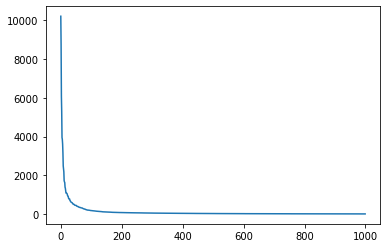

In [18]:
# Let's plot the count of the 1000 most used words:

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

wc = Counter()
for text in corpus:
    wc.update(text.split(" "))
    
freq = [f for w,f in wc.most_common(1000)]

plt.plot(freq[:1000])
print(wc.most_common(20))

**Let's remove stopwords:** english stop words: direclty on sklearn 

- **stop_words:** string {‘english’}, list, or None (default)
    - If ‘english’, a built-in stop word list for English is used. There are several known issues with ‘english’ and you should consider an alternative (see Using stop words).
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens. Only applies if analyzer == 'word'.
    - If None, no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [19]:
# French stop words: nltk
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
final_stopwords_list = stopwords.words('english') + stopwords.words('french')
#print(final_stopwords_list)
vectorizer = CountVectorizer(stop_words=final_stopwords_list)
#vectorizer = TfidfVectorizer(stop_words=final_stopwords_list)

**Build your own list**

In [12]:
# CountVectorizer can take a list of stop words as argument.
# Build or download a list of stop word (from NLTK for exemple)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

# remove stop words
stop_words = list(stopwords.words('french'))

vectorizer = CountVectorizer(stop_words=stop_words)
print(X.shape)
X = vectorizer.fit_transform(corpus)
X.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(8738, 12617)


(8738, 12504)

In [ ]:
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)
# for i in range(len(X_test)):
#     stemmer.stemWords(X_test[i].split()[j] for j in range(len(X_test[i].split())))

**(b) Dictionary processing, restricting vocabulary size: corpus-specific stopwords** => max_df + suppress rare words (min_df) + max_features 

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

- **min_df:** float in range [0.0, 1.0] or int, default=1
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

- **max_features:** int or None, default=None
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
This parameter is ignored if vocabulary is not None.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [22]:
# max_df: float (ratio) / integer(number) of document above which we remove the word)
# min_df: float (ratio) / integer(number) of document under which we remove the word)

min_df=5
max_df=0.5
max_features=10000
vectorizer = CountVectorizer(max_df=max_df,min_df=min_df,max_features=max_features)  #try out some values
X = vectorizer.fit_transform(corpus)
#What is the dictionnary size now ?
dic_size = X.shape[1]###
print(dic_size)

3484


**(c) : Binary BoW**: instead of word counts, the bag of word vector can only represent used word.

- **binary:** boolean, default=False
If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [20]:
min_df=5
max_df=0.5
max_features=10000
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(corpus)
dic_size = X.shape[1]###
print(X.shape)

print(type(X))

(8738, 12617)
<class 'scipy.sparse.csr.csr_matrix'>


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

use_idf=True,          
smooth_idf=True
sublinear_tf=False

vectorizer = TfidfVectorizer(use_idf= use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)
X = vectorizer.fit_transform(corpus)
print(X.shape)

(8738, 12617)


**(e) n-grams**: instead of words, consider n-uplets of words as tokens

- **ngram_range:** tuple (min_n, max_n)
The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

- **analyzer:** string, {‘word’, ‘char’, ‘char_wb’} or callable
Whether the feature should be made of word or character n-grams. Option ‘char_wb’ creates character n-grams only from text inside word boundaries; n-grams at the edges of words are padded with space.
If a callable is passed it is used to extract the sequence of features out of the raw, unprocessed input.

[see CountVectorizer for full doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [22]:
ngram_range = (1,2) # unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=ngram_range,analyzer='word') # Maybe 2-grams or 3-grams bring improvements ?
X = vectorizer.fit_transform(corpus)
#What is the dictionnary size now ?
dic_size = X.shape[1]###
print(dic_size)

91946


# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

In [24]:
# On se limite au premier modèle de représentation bow
vectorizer = CountVectorizer(preprocessor=preprocess)
X = vectorizer.fit_transform(corpus)

In [26]:
# La taille d'origine du vocabulaire
print('Taille du vocabulaire :', X.shape[1])

Taille du vocabulaire : 12098


(-0.5, 399.5, 199.5, -0.5)

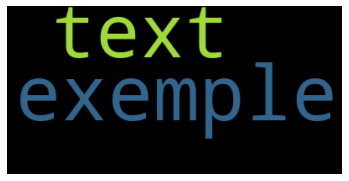

In [27]:
# Que se passe t'il si on ne garde que les 100 mots les plus fréquents
from wordcloud import WordCloud

# Get text:
text = "this is exemple text"

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

Avant de lancer une grande expérimentation, il est en effet important de construire une base de travail solide et de répondre à certaines questions clés pour assurer la qualité de la recherche. Voici quelques éléments de réponse aux questions que vous avez posées :

- Le temps nécessaire pour apprendre un classifieur (NB/SVM/RegLog) dépend de plusieurs facteurs, tels que la taille du corpus, la taille du vocabulaire, la complexité du modèle et les ressources de calcul disponibles. Pour estimer le temps d'apprentissage, il est recommandé de réaliser des expériences préliminaires sur un échantillon du corpus, en faisant varier la taille du vocabulaire, et de mesurer le temps nécessaire pour entraîner le modèle. Cela permettra de déterminer le temps approximatif nécessaire pour entraîner un modèle sur l'ensemble du corpus.

- La validation croisée est généralement recommandée pour évaluer les performances d'un modèle de manière robuste et fiable. Cela permet d'éviter les biais liés à la partition des données et de garantir une évaluation plus objective des performances. Un simple split des données en deux parties (train/test) peut donner des résultats biaisés en fonction de la distribution des classes et des exemples dans chaque partie. La validation croisée permet de réduire ce biais en utilisant plusieurs partitions différentes et en moyennant les performances sur l'ensemble des partitions.

- La stabilité de la validation croisée dépend de plusieurs facteurs, tels que le nombre de partitions (folds), la taille de chaque partition, la distribution des classes et des exemples dans chaque partition, et la variabilité des performances du modèle. Pour évaluer la stabilité de la validation croisée, il est recommandé de réaliser des expériences avec différentes graines aléatoires, en faisant varier le nombre de folds, et de mesurer les performances moyennes et leur variabilité. En général, il est recommandé d'utiliser au moins 5-10 folds pour une estimation fiable des performances, mais ce nombre peut varier en fonction de la taille du corpus et de la complexité du modèle.

 # Post traitement
 A kindof aposteriori on the data using the apriori of : if one locutor speaks